# Proyek Klasifikasi Gambar: Diabetic Retinopathy Detection
- **Nama:** Arvin Azmi Sava
- **Email:** arvinazmisava0711@gmail.com
- **ID Dicoding:** [Input Username]

## Import Semua Packages/Library yang Digunakan

In [1]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [2]:
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [4]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arvinazmisava","key":"e4147832186080a4facc50b04539e2c6"}'}

In [5]:
# Download Kaggle dataset and unzip the file
# !cp kaggle.json ~/.kaggle/

# !chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d sovitrath/diabetic-retinopathy-224x224-gaussian-filtered
!unzip diabetic-retinopathy-224x224-gaussian-filtered.zip


Dataset URL: https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-gaussian-filtered
License(s): CC0-1.0
 99% 424M/427M [00:03<00:00, 145MB/s]
100% 427M/427M [00:03<00:00, 138MB/s]
Archive:  diabetic-retinopathy-224x224-gaussian-filtered.zip
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/0024cdab0c1e.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/00cb6555d108.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/0124dffecf29.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/01b3aed3ed4c.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/0369f3efe69b.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/03e25101e8e8.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/04ac765f91a1.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/059bc89df7f4.png  
  inflating: gaussian_filtered_images/gaussia

### Data Preprocessing

In [6]:
# Direktori awal untuk train dan test
train_dir = "diabetic_retinopathy/train"
test_dir = "diabetic_retinopathy/test"

# Direktori baru untuk dataset gabungan
combined_dir = "diabetic_retinopathy/dataset"



In [7]:
os.makedirs("diabetic_retinopathy/train", exist_ok=True)
os.makedirs("diabetic_retinopathy/test", exist_ok=True)


In [8]:
# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

In [9]:
# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

In [10]:
path = "/content/gaussian_filtered_images/gaussian_filtered_images"


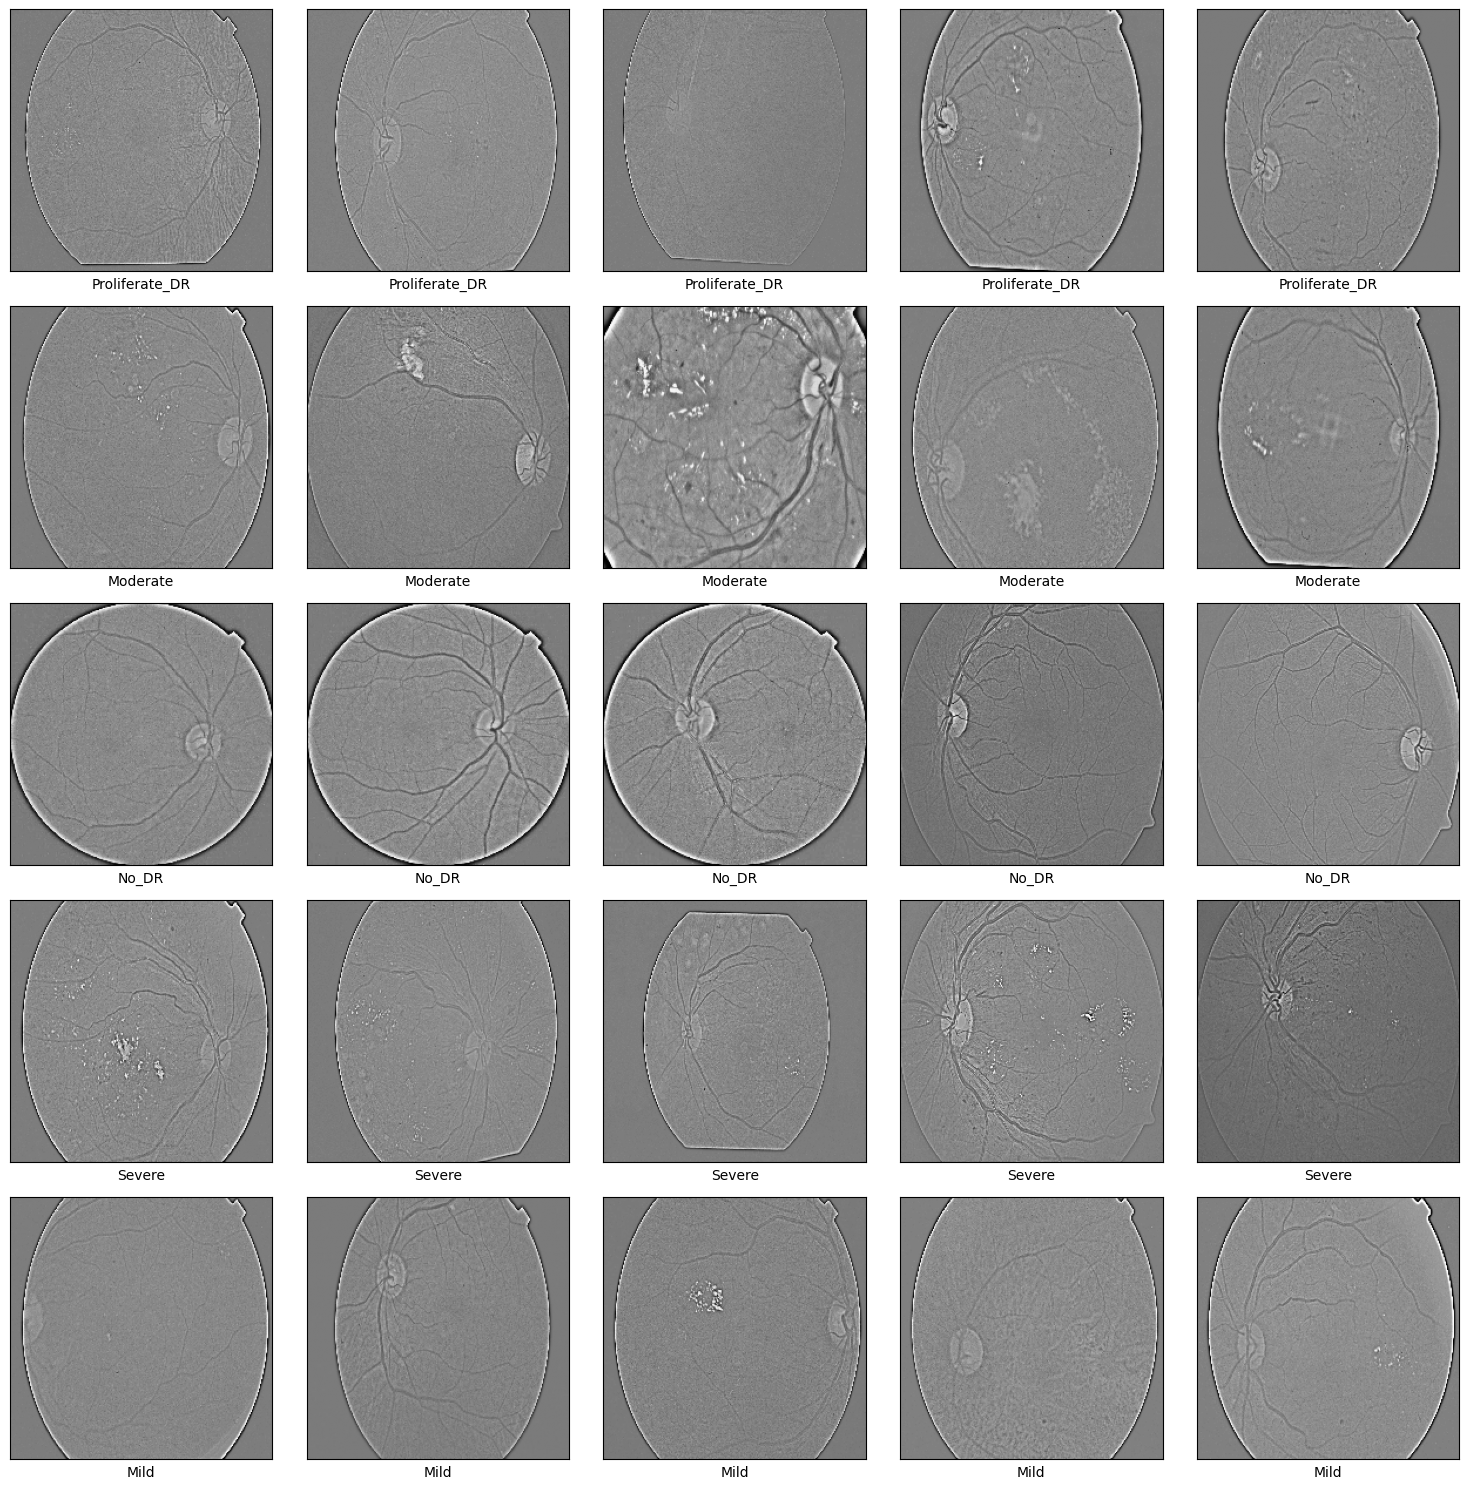

In [11]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Path dataset yang sudah diekstrak
#path = "/content/diabetic_retinopathy/gaussian_filtered_images/gaussian_filtered_images"

# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
lung_image = {}

# Menyusun kamus berdasarkan kelas gambar
for class_name in os.listdir(path):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):  # Pastikan itu adalah folder kelas
        lung_image[class_name] = os.listdir(class_path)

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(lung_image), 5, figsize=(15, 15))

for i, (class_name, images) in enumerate(lung_image.items()):
    selected_images = random.sample(images, 5)  # Pilih 5 gambar secara acak

    for j, image_name in enumerate(selected_images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()
plt.show()


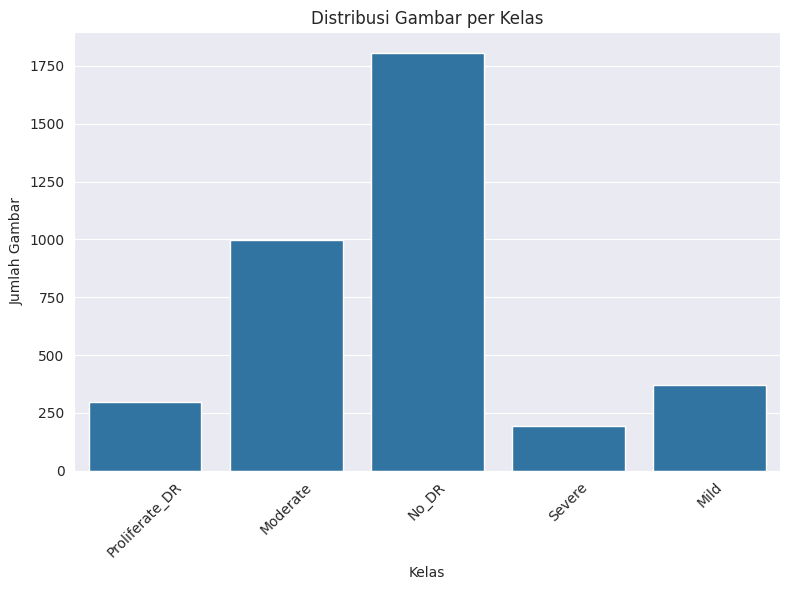

In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definisikan path sumber
lung_path = "/content/gaussian_filtered_images/gaussian_filtered_images/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        # Filter hanya gambar dengan ekstensi yang diinginkan (misalnya png, jpg, dsb)
        if name.lower().endswith(('.png', '.jpg', '.jpeg')):
            full_path.append(os.path.join(path, name))
            labels.append(path.split('/')[-1])  # Mengambil nama folder sebagai label
            file_name.append(name)

# Membuat DataFrame dengan informasi file
distribution_train = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Plot distribusi gambar di setiap kelas
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(data=distribution_train, x='labels')
plt.title("Distribusi Gambar per Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


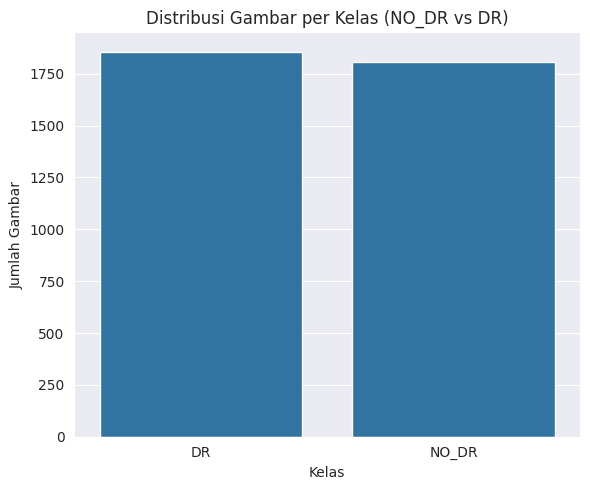

In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definisikan path sumber
lung_path = "/content/gaussian_filtered_images/gaussian_filtered_images/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        if name.lower().endswith(('.png', '.jpg', '.jpeg')):
            full_path.append(os.path.join(path, name))
            original_label = path.split('/')[-1]  # Mengambil nama folder sebagai label

            # Ubah menjadi dua kelas: NO_DR dan DR
            if original_label == "No_DR":
                labels.append("NO_DR")
            else:
                labels.append("DR")

            file_name.append(name)

# Membuat DataFrame dengan informasi file
distribution_train = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Plot distribusi gambar di setiap kelas
plt.figure(figsize=(6, 5))
sns.set_style("darkgrid")
plot_data = sns.countplot(data=distribution_train, x='labels')
plt.title("Distribusi Gambar per Kelas (NO_DR vs DR)")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


#### Split Dataset

In [14]:
import os
import pandas as pd

# Panggil variabel mypath yang menampung folder dataset gambar
mypath = '/content/gaussian_filtered_images/gaussian_filtered_images/'

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        original_label = path.split('/')[-1]  # Ambil nama folder sebagai label

        # Ubah label menjadi 2 kelas: NO_DR dan DR
        if original_label == 'No_DR':
            new_label = 'NO_DR'
        else:
            new_label = 'DR'

        labels.append(new_label)
        file_name.append(name)

# Buat DataFrame
df = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()


,0
labels,
DR,1858
NO_DR,1805


In [15]:
# Variabel yang digunakan pada pemisahan data ini di mana variabel x = data path dan y = data labels

X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [16]:
# Menyatukan ke dalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [17]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "chest_xray/dataset/"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"


set    labels
test   DR         363
       NO_DR      370
train  DR        1495
       NO_DR     1435
dtype: int64 


                                                   path labels    set
3588  /content/gaussian_filtered_images/gaussian_fil...  NO_DR   test
991   /content/gaussian_filtered_images/gaussian_fil...     DR  train
3296  /content/gaussian_filtered_images/gaussian_fil...     DR   test
944   /content/gaussian_filtered_images/gaussian_fil...  NO_DR  train
2602  /content/gaussian_filtered_images/gaussian_fil...  NO_DR  train


In [18]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [20]:
# Definisikan direktori training dan test
TRAIN_DIR = "/content/Dataset-Final/train"
TEST_DIR = "/content/Dataset-Final/test"

train_DR = os.path.join(TRAIN_DIR + '/DR')
train_normal = os.path.join(TRAIN_DIR + '/NO_DR')

test_DR = os.path.join(TEST_DIR + '/DR')
test_normal = os.path.join(TEST_DIR + '/NO_DR')

print('Total training DR images:', len(os.listdir(train_DR)))
print('Total training normal images:', len(os.listdir(train_normal)))

print('Total test DR images:', len(os.listdir(test_DR)))
print('Total test normal images:', len(os.listdir(test_normal)))




Total training DR images: 1495
Total training normal images: 1435
Total test DR images: 363
Total test normal images: 370


In [21]:
# Buat objek ImageDataGenerator yang menormalkan gambar
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="grayscale",
                                              class_mode='binary',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                color_mode="grayscale",
                                                   class_mode='binary',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="grayscale",
                                                  class_mode='binary',
                                                  shuffle=False)

Found 2344 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 733 images belonging to 2 classes.


## Modelling

In [24]:
import tensorflow as tf
from tensorflow.keras import layers, callbacks

# Callback functions
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',  # Memantau loss validasi
    patience=5,          # Berhenti jika tidak ada perbaikan selama 5 epoch
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Memantau loss validasi
    factor=0.5,          # Mengurangi learning rate menjadi setengah jika stagnan
    patience=3,          # Setelah 3 epoch tanpa peningkatan
    verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    filepath='best_model.h5',  # Simpan model terbaik ke file
    monitor='val_loss',
    save_best_only=True
)

# Building the model for binary classification (2 classes: NO_DR vs. DR)
model = tf.keras.Sequential([
    # First Convolutional Layer
    layers.Conv2D(8, (3, 3), padding="valid", input_shape=(150, 150, 1), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    # Second Convolutional Layer
    layers.Conv2D(16, (3, 3), padding="valid", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    # Third Convolutional Layer
    layers.Conv2D(32, (4, 4), padding="valid", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    # Flatten the output for fully connected layers
    layers.Flatten(),

    # Dense Layer with ReLU activation
    layers.Dense(32, activation='relu'),

    # Dropout for regularization
    layers.Dropout(0.15),

    # Output Layer with 'softmax' activation for binary classification (2 classes)
    layers.Dense(2, activation='softmax')  # Mengubah dari 5 kelas ke 2 kelas (NO_DR vs. DR)
])



# Print the summary of the model
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 148, 148, 8)         │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 74, 74, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 74, 74, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 72, 72, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 36, 36, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 36, 36, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 33, 33, 32)          │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │         262,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 271,938 (1.04 MB)

 Trainable params: 271,826 (1.04 MB)

 Non-trainable params: 112 (448.00 B)

In [25]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',  # Gunakan sparse categorical crossentropy untuk multi-class
              metrics=['accuracy'])

# Fit the model with callbacks
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/30


Exception ignored in: <function _xla_gc_callback at 0x7aaedd389e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.5462 - loss: 1.1063

74/74 ━━━━━━━━━━━━━━━━━━━━ 85s 567ms/step - accuracy: 0.5481 - loss: 1.1010 - val_accuracy: 0.5094 - val_loss: 0.7504 - learning_rate: 1.0000e-05
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 38s 514ms/step - accuracy: 0.8691 - loss: 0.3474 - val_accuracy: 0.5094 - val_loss: 0.8703 - learning_rate: 1.0000e-05
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 38s 511ms/step - accuracy: 0.8936 - loss: 0.2857 - val_accuracy: 0.5094 - val_loss: 0.9625 - learning_rate: 1.0000e-05
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.8928 - loss: 0.2736
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 550ms/step - accuracy: 0.8928 - loss: 0.2734 - val_accuracy: 0.5094 - val_loss: 0.9229 - learning_rate: 1.0000e-05
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 38s 511ms/step - accuracy: 0.9055 - loss: 0.2530 - val_accuracy: 0.5436 - val_loss: 0.8090 - learning_rate: 5.0000e-06
Epoch 6/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.9017 - lo

74/74 ━━━━━━━━━━━━━━━━━━━━ 40s 504ms/step - accuracy: 0.9018 - loss: 0.2513 - val_accuracy: 0.6462 - val_loss: 0.5747 - learning_rate: 5.0000e-06
Epoch 7/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.9141 - loss: 0.2298

74/74 ━━━━━━━━━━━━━━━━━━━━ 39s 521ms/step - accuracy: 0.9141 - loss: 0.2299 - val_accuracy: 0.7778 - val_loss: 0.4119 - learning_rate: 5.0000e-06
Epoch 8/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.9140 - loss: 0.2186

74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 548ms/step - accuracy: 0.9141 - loss: 0.2187 - val_accuracy: 0.8564 - val_loss: 0.3040 - learning_rate: 5.0000e-06
Epoch 9/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.9241 - loss: 0.2080

74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 558ms/step - accuracy: 0.9240 - loss: 0.2082 - val_accuracy: 0.8889 - val_loss: 0.2471 - learning_rate: 5.0000e-06
Epoch 10/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.9190 - loss: 0.2206

74/74 ━━━━━━━━━━━━━━━━━━━━ 82s 556ms/step - accuracy: 0.9190 - loss: 0.2206 - val_accuracy: 0.9009 - val_loss: 0.2293 - learning_rate: 5.0000e-06
Epoch 11/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.9130 - loss: 0.2211

74/74 ━━━━━━━━━━━━━━━━━━━━ 39s 522ms/step - accuracy: 0.9132 - loss: 0.2209 - val_accuracy: 0.9060 - val_loss: 0.2214 - learning_rate: 5.0000e-06
Epoch 12/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.9149 - loss: 0.2165

74/74 ━━━━━━━━━━━━━━━━━━━━ 44s 564ms/step - accuracy: 0.9150 - loss: 0.2164 - val_accuracy: 0.9094 - val_loss: 0.2180 - learning_rate: 5.0000e-06
Epoch 13/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.9204 - loss: 0.1960

74/74 ━━━━━━━━━━━━━━━━━━━━ 39s 525ms/step - accuracy: 0.9204 - loss: 0.1960 - val_accuracy: 0.9077 - val_loss: 0.2153 - learning_rate: 5.0000e-06
Epoch 14/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 43s 584ms/step - accuracy: 0.9275 - loss: 0.1983 - val_accuracy: 0.9060 - val_loss: 0.2156 - learning_rate: 5.0000e-06
Epoch 15/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.9304 - loss: 0.1932

74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 552ms/step - accuracy: 0.9304 - loss: 0.1932 - val_accuracy: 0.9043 - val_loss: 0.2137 - learning_rate: 5.0000e-06
Epoch 16/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.9315 - loss: 0.1853

74/74 ━━━━━━━━━━━━━━━━━━━━ 39s 522ms/step - accuracy: 0.9314 - loss: 0.1853 - val_accuracy: 0.9060 - val_loss: 0.2119 - learning_rate: 5.0000e-06
Epoch 17/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.9338 - loss: 0.1911

74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 517ms/step - accuracy: 0.9338 - loss: 0.1910 - val_accuracy: 0.9043 - val_loss: 0.2104 - learning_rate: 5.0000e-06
Epoch 18/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.9430 - loss: 0.1679

74/74 ━━━━━━━━━━━━━━━━━━━━ 39s 533ms/step - accuracy: 0.9429 - loss: 0.1680 - val_accuracy: 0.9060 - val_loss: 0.2084 - learning_rate: 5.0000e-06
Epoch 19/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.9324 - loss: 0.1903

74/74 ━━━━━━━━━━━━━━━━━━━━ 38s 517ms/step - accuracy: 0.9324 - loss: 0.1903 - val_accuracy: 0.9060 - val_loss: 0.2068 - learning_rate: 5.0000e-06
Epoch 20/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 39s 527ms/step - accuracy: 0.9375 - loss: 0.1878 - val_accuracy: 0.9043 - val_loss: 0.2089 - learning_rate: 5.0000e-06
Epoch 21/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9278 - loss: 0.1816

74/74 ━━━━━━━━━━━━━━━━━━━━ 39s 528ms/step - accuracy: 0.9279 - loss: 0.1815 - val_accuracy: 0.9077 - val_loss: 0.2058 - learning_rate: 5.0000e-06
Epoch 22/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.9374 - loss: 0.1693

74/74 ━━━━━━━━━━━━━━━━━━━━ 39s 527ms/step - accuracy: 0.9374 - loss: 0.1693 - val_accuracy: 0.9077 - val_loss: 0.2050 - learning_rate: 5.0000e-06
Epoch 23/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.9357 - loss: 0.1719

74/74 ━━━━━━━━━━━━━━━━━━━━ 39s 526ms/step - accuracy: 0.9357 - loss: 0.1719 - val_accuracy: 0.9094 - val_loss: 0.2044 - learning_rate: 5.0000e-06
Epoch 24/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.9471 - loss: 0.1529

74/74 ━━━━━━━━━━━━━━━━━━━━ 39s 531ms/step - accuracy: 0.9470 - loss: 0.1530 - val_accuracy: 0.9094 - val_loss: 0.2000 - learning_rate: 5.0000e-06
Epoch 25/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 39s 525ms/step - accuracy: 0.9429 - loss: 0.1659 - val_accuracy: 0.9111 - val_loss: 0.2024 - learning_rate: 5.0000e-06
Epoch 26/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 57s 781ms/step - accuracy: 0.9388 - loss: 0.1632 - val_accuracy: 0.9111 - val_loss: 0.2012 - learning_rate: 5.0000e-06
Epoch 27/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.9499 - loss: 0.1459

74/74 ━━━━━━━━━━━━━━━━━━━━ 42s 572ms/step - accuracy: 0.9498 - loss: 0.1460 - val_accuracy: 0.9128 - val_loss: 0.1986 - learning_rate: 5.0000e-06
Epoch 28/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 44s 597ms/step - accuracy: 0.9473 - loss: 0.1541 - val_accuracy: 0.9111 - val_loss: 0.1994 - learning_rate: 5.0000e-06
Epoch 29/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.9498 - loss: 0.1393

74/74 ━━━━━━━━━━━━━━━━━━━━ 38s 511ms/step - accuracy: 0.9498 - loss: 0.1395 - val_accuracy: 0.9128 - val_loss: 0.1976 - learning_rate: 5.0000e-06
Epoch 30/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.9415 - loss: 0.1600

74/74 ━━━━━━━━━━━━━━━━━━━━ 38s 514ms/step - accuracy: 0.9416 - loss: 0.1599 - val_accuracy: 0.9128 - val_loss: 0.1963 - learning_rate: 5.0000e-06


## Evaluasi dan Visualisasi

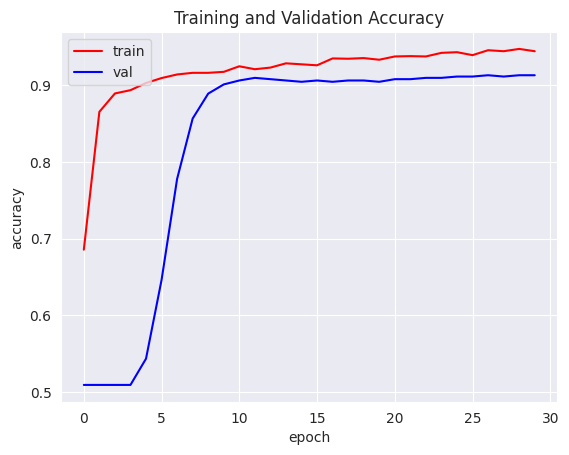

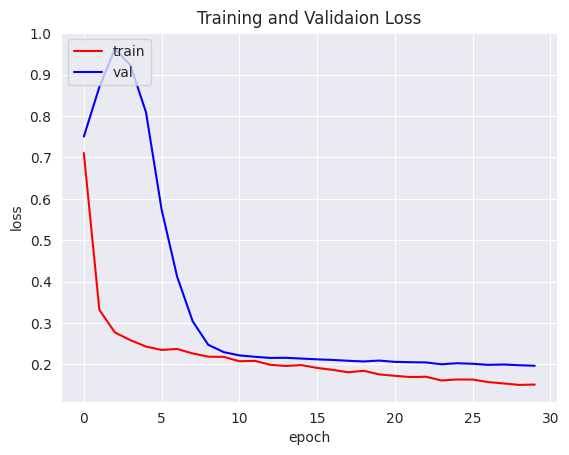

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

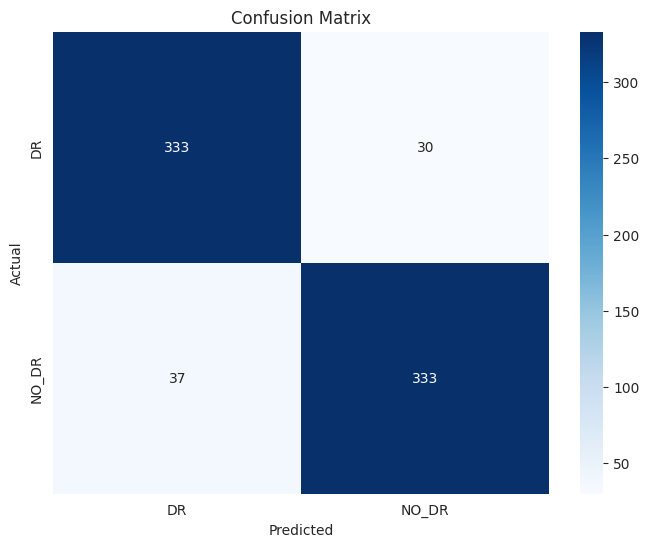



              precision    recall  f1-score   support

          DR     0.9000    0.9174    0.9086       363
       NO_DR     0.9174    0.9000    0.9086       370

    accuracy                         0.9086       733
   macro avg     0.9087    0.9087    0.9086       733
weighted avg     0.9088    0.9086    0.9086       733



In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Reset the test generator
test_generator.reset()

# Predict the classes on the test set
preds_1 = model.predict(test_generator, verbose=0)

# For multi-class classification, we don't need to threshold the predictions as in binary classification.
# We'll just take the class with the highest probability for each prediction
preds_1 = np.argmax(preds_1, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(test_generator.classes, preds_1)

# Plot the confusion matrix as a heatmap
cm_df = pd.DataFrame(cm, index=test_generator.class_indices.keys(), columns=test_generator.class_indices.keys())
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
class_names = list(test_generator.class_indices.keys())  # List of class names
print("\n")
print(classification_report(test_generator.classes, preds_1, target_names=class_names, digits=4))


## Konversi Model

In [30]:
!pip install tensorflowjs


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


In [32]:
import tensorflow as tf
import tensorflowjs as tfjs

# Simpan model dalam format SavedModel
saved_model_dir = "saved_model"
model.export(saved_model_dir)  # Use model.export() for SavedModel format

# Konversi dan simpan model ke format TensorFlow.js
tfjs_target_dir = "tfjs_model"
tfjs.converters.save_keras_model(model, tfjs_target_dir)

# Konversi dan simpan model ke format TensorFlow Lite
tflite_converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = tflite_converter.convert()

# Simpan model TFLite ke file
tflite_model_path = "model.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(" Model telah dikonversi dan disimpan dalam format:")
print(f"- SavedModel: {saved_model_dir}/")
print(f"- TensorFlow.js: {tfjs_target_dir}/")
print(f"- TensorFlow Lite: {tflite_model_path}")


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 1), dtype=tf.float32, name='keras_tensor_28')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  134891140934800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134890977217040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134890977217232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134890977215504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134890977214928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134890977216848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134890977218768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134890977219344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134890977219536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134890977218384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134890977215120:

failed to lookup keras version from the file,
    this is likely a weight only file
 Model telah dikonversi dan disimpan dalam format:
- SavedModel: saved_model/
- TensorFlow.js: tfjs_model/
- TensorFlow Lite: model.tflite


In [33]:
pip freeze > requirements.txt